In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [3]:

# 필요한 라이브러리 불러오기
import warnings
warnings.filterwarnings("ignore")
import os 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
#plt.style.use('seaborn')
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense,LeakyReLU,BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>📊 data summary:</font></h3>

신용카드 사기는 가짜, 만료된 신용카드를 고의로 사용하거나, 다른 사람의 신용카드를 이용하여 재산을 획득하거나, 자신의 신용카드를 악의적으로 과도하게 사용하는 행위를 말합니다. 신용카드 사기의 형태는 세 가지로 나뉩니다: 카드 분실 이용, 가짜 신청, 그리고 가짜 신용카드입니다. 사기 사건 중 60% 이상이 가짜 신용카드로 사기를 치는데, 이는 조직적인 성격을 띠고 있습니다. 카드 정보를 훔치고, 가짜 카드를 만들고, 가짜 카드를 팔고, 가짜 카드를 사용하여 범죄를 저지르는 과정을 통해 엄청난 이익을 얻습니다. 그리고 신용카드 사기 탐지는 은행이 손실을 줄이는 중요한 방법입니다.

해당 데이터셋은 2013년 9월에 유럽 카드 소유자가 신용카드를 통해 실시한 거래 정보를 포함하고 있습니다. 이 데이터셋은 두 날 동안 발생한 거래를 보여주는데, 284,807 건의 거래 중 492 건의 사기가 있었습니다. 데이터셋은 매우 불균형하며, 긍정적인 클래스(사기)는 모든 거래의 0.172%에 불과합니다. 원래 데이터셋은 비식별화와 PCA 처리가 완료되었으며, 익명의 변수 V1, V2, ...V28은 PCA를 통해 얻은 주성분입니다. PCA를 통해 처리되지 않은 유일한 변수는 Time과 Amount입니다. Time은 각 거래와 데이터셋 내 첫 번째 거래 사이의 간격이며, 단위는 초입니다. Amount는 거래 금액입니다. Class는 분류 변수로, 사기가 발생할 경우 1, 그렇지 않을 경우 0입니다. 프로젝트의 목표는 현재 데이터셋을 바탕으로 분류 모델을 구축하고, 신용카드 사기 행위를 탐지하는 것입니다.


오토인코더는 복잡한 것처럼 들릴 수 있지만, 기본 개념은 간단합니다. 자, 고등학생에게 설명한다면 다음과 같이 시작할 수 있겠네요.

오토인코더를 생각하는 가장 쉬운 방법은 정보를 압축하고 복원하는 기계라고 생각하는 것입니다. 어떻게 작동하는지 쉬운 예를 들어 볼게요. 당신이 학교에서 많은 과제를 받았다고 상상해보세요. 이 모든 과제들을 가방에 넣으려 하지만, 가방이 너무 작아서 다 들어가지 않아요. 이 때 당신이 할 수 있는 일은? 

가장 중요한 것들만 가방에 넣고, 덜 중요한 것들은 빼는 것입니다. 이것이 바로 인코더가 하는 일입니다. 인코더는 데이터의 가장 중요한 정보(핵심 특징)만을 추출하여 압축시키고, 덜 중요한 정보는 무시합니다.

이제 가방에 모든 중요한 것들이 들어갔다고 생각해봅시다. 그런데 이제 당신은 학교에 도착해 그것들을 다시 펼쳐야 합니다. 당신이 할 일은 가방에서 물건들을 꺼내 원래의 크기로 펼치는 것입니다. 이것이 디코더의 역할입니다. 디코더는 인코더가 압축한 정보를 바탕으로 원래의 데이터를 복원합니다. 

하지만 중요한 것은, 복원된 데이터는 완벽하게 원래와 동일하지 않을 수 있다는 것입니다. 왜냐하면 인코더는 압축 과정에서 일부 정보를 버렸기 때문이죠. 그러나, 오토인코더는 핵심 특징들을 유지하면서 데이터를 효과적으로 압축하고 복원하는 방법을 학습합니다. 이러한 특성 때문에 오토인코더는 효과적인 차원 축소 도구로서 사용되며, 잡음 제거나 이상 탐지 등에도 적용됩니다.

Autoencoder는 본질적으로 고차원 입력의 저차원 표현을 생성하는 데 신경망을 사용합니다. Autoencoder는 주성분 분석(PCA)와 유사하지만, 비선형 활성화 함수를 사용할 때 PCA의 선형적 제한을 극복합니다.

Autoencoder는 두 가지 주요 부분, 즉 인코더와 디코더를 포함합니다. 인코더의 역할은 주어진 데이터의 압축 표현을 발견하는 것이며, 디코더는 원래의 입력을 재구성하는 데 사용됩니다. 훈련 과정에서, 디코더는 autoencoder에 가장 정보가 많은 특징을 선택하도록 강제하며, 이는 결국 압축된 표현에 저장됩니다. 최종적으로 압축된 표현은 중간의 coder 계층에 저장됩니다.

아래의 그림을 예로 들면, 원시 데이터의 차원은 10이고, 인코더와 디코더는 각각 두 개의 계층을 가지며, 중간의 coder는 총 3개의 노드를 가지고 있습니다. 이는 원시 데이터가 3차원으로 감소되었음을 의미합니다. 디코더는 차원이 줄어든 데이터를 바탕으로 원시 데이터를 재구성하고, 다시 10차원의 출력을 얻습니다. 입력부터 출력까지의 이 과정에서, autoencoder는 실제로 잡음 감소의 역할을 하게 됩니다.

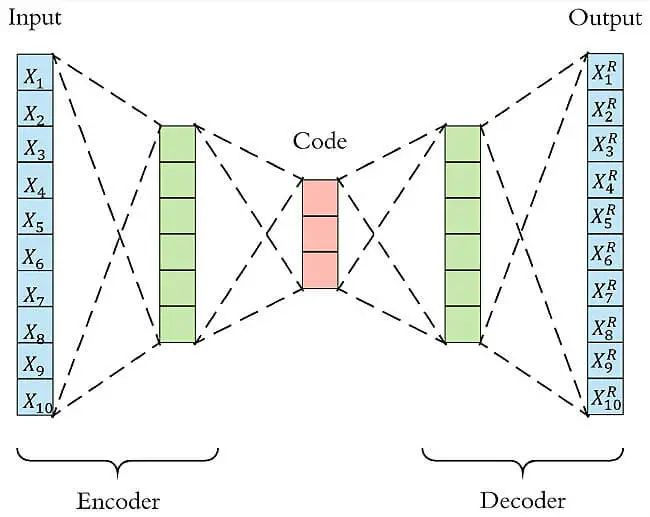

이상 탐지(anomaly detection)는 일반적으로 지도 학습과 비지도 학습 두 가지로 나뉩니다. 비지도 학습의 경우, 우리는 학습을 위해 사용할 이상 샘플을 가지고 있지 않으며, 알고리즘은 기본적으로 이상치가 다른 분포를 따른다고 가정합니다. 정상 데이터를 통해 훈련된 Autoencoder는 정상 샘플을 재구성할 수 있지만, 정상 분포와 다른 데이터 포인트는 잘 재구성하지 못하며, 이로 인해 재구성 오차가 커집니다.

만약 샘플의 특성이 모두 수치형 변수라면, 우리는 MSE(평균 제곱 오차)나 MAE(평균 절대 오차)를 재구성 오차로 사용할 수 있습니다. 예를 들어, 아래의 그림과 같이 입력 샘플이 있다고 가정합시다.
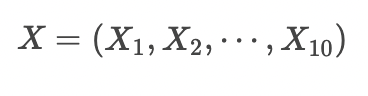


오토인코더를 통해 복원된 결과는 다음과 같습니다:

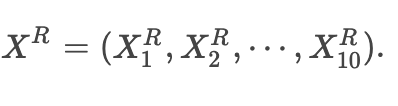


환원오차MSE는

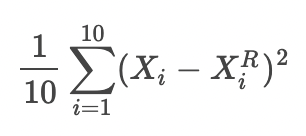

MSE는 

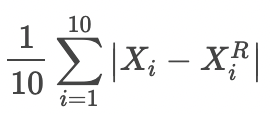

가 됩니다.

In [4]:
d = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

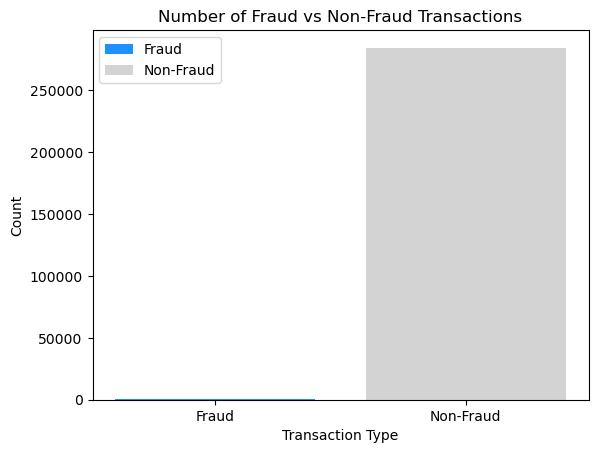

In [5]:
num_nonfraud = np.sum(d['Class'] == 0)  # 'Class' 열에서 값이 0인 비사기 거래의 개수를 계산합니다.
num_fraud = np.sum(d['Class'] == 1)  # 'Class' 열에서 값이 1인 사기 거래의 개수를 계산합니다.

fraud_label = 'Fraud'  # 사기 거래를 나타내는 레이블입니다.
nonfraud_label = 'Non-Fraud'  # 비사기 거래를 나타내는 레이블입니다.

fraud_count = [num_fraud]  # 사기 거래 개수를 리스트에 담습니다.
nonfraud_count = [num_nonfraud]  # 비사기 거래 개수를 리스트에 담습니다.

plt.bar(fraud_label, fraud_count, color='dodgerblue', label='Fraud')  # 사기 거래를 나타내는 막대 그래프를 생성합니다.
plt.bar(nonfraud_label, nonfraud_count, color='lightgrey', label='Non-Fraud')  # 비사기 거래를 나타내는 막대 그래프를 생성합니다.

plt.xlabel('Transaction Type')  # x축 레이블을 설정합니다.
plt.ylabel('Count')  # y축 레이블을 설정합니다.
plt.title('Number of Fraud vs Non-Fraud Transactions')  # 그래프의 제목을 설정합니다.

plt.legend()  # 범례를 표시합니다.
plt.show()  # 그래프를 출력합니다.

1. 'Class' 열에서 값이 0인 비사기 거래의 개수를 계산합니다.
2. 'Class' 열에서 값이 1인 사기 거래의 개수를 계산합니다.
3. 사기 거래를 나타내는 레이블을 정의합니다.
4. 비사기 거래를 나타내는 레이블을 정의합니다.
5. 사기 거래 개수를 리스트에 담습니다.
6. 비사기 거래 개수를 리스트에 담습니다.
7. 사기 거래를 나타내는 막대 그래프를 생성하고, 색상과 레이블을 설정합니다.
8. 비사기 거래를 나타내는 막대 그래프를 생성하고, 색상과 레이블을 설정합니다.
9. x축 레이블을 설정합니다.
10. y축 레이블을 설정합니다.
11. 그래프의 제목을 설정합니다.
12. 범례를 표시합니다.
13. 그래프를 출력합니다.

In [6]:
data = d.drop(['Time'], axis=1)  # 'Time' 열을 제거한 데이터프레임을 생성합니다.
data['Amount'] = StandardScaler().fit_transform(data[['Amount']])  # 'Amount' 열의 데이터를 표준화(StandardScaler)합니다.
X = data.drop(['Class'],axis=1)  # 'Class' 열을 제외한 나머지 열을 X에 할당합니다.
Y = data.Class  # 'Class' 열을 Y에 할당합니다.


1. 'Time' 열을 제거한 데이터프레임을 생성합니다.
2. 'Amount' 열의 데이터를 표준화(StandardScaler)합니다. 이는 'Amount' 열의 값들을 평균과 표준편차를 기준으로 표준화하여 데이터의 스케일을 맞추는 작업입니다.
3. 'Class' 열을 제외한 나머지 열을 X에 할당합니다. 이는 입력 데이터로 사용될 특성(독립 변수)들을 의미합니다.
4. 'Class' 열을 Y에 할당합니다. 이는 출력 데이터로 사용될 타깃(종속 변수)을 의미합니다.

In [7]:
# Autoencoder의 파라미터 설정
input_dim = X.shape[1]  # 입력 차원 설정
encoding_dim = 128  # 인코딩 차원 설정
num_epoch = 30  # 에포크 횟수 설정
batch_size = 256  # 배치 크기 설정

input_layer = Input(shape=(input_dim, ))  # 입력 레이어 정의

# 인코더 레이어 정의
encoder = Dense(encoding_dim,
                activation="tanh",
                activity_regularizer=regularizers.l1(10e-5)
                )(input_layer)  # 인코딩 레이어 설정 및 활성화 함수, 정규화 설정
encoder = BatchNormalization()(encoder)  # 배치 정규화 적용
encoder = LeakyReLU(alpha=0.2)(encoder)  # LeakyReLU 활성화 함수 적용

encoder = Dense(int(encoding_dim/2),
                activation="relu"
                )(encoder)  # 인코딩 레이어 설정 및 활성화 함수
encoder = BatchNormalization()(encoder)  # 배치 정규화 적용
encoder = LeakyReLU(alpha=0.1)(encoder)  # LeakyReLU 활성화 함수 적용

encoder = Dense(int(encoding_dim/4),
                activation="relu"
                )(encoder)  # 인코딩 레이어 설정 및 활성화 함수
encoder = BatchNormalization()(encoder)  # 배치 정규화 적용

# 디코더 레이어 정의
decoder = LeakyReLU(alpha=0.1)(encoder)  # LeakyReLU 활성화 함수 적용
decoder = Dense(int(encoding_dim/4),
                activation='tanh'
                )(decoder)  # 디코딩 레이어 설정 및 활성화 함수
decoder = BatchNormalization()(decoder)  # 배치 정규화 적용
decoder = LeakyReLU(alpha=0.1)(decoder)  # LeakyReLU 활성화 함수 적용

decoder = Dense(int(encoding_dim/2),
                activation='tanh'
                )(decoder)  # 디코딩 레이어 설정 및 활성화 함수
decoder = BatchNormalization()(decoder)  # 배치 정규화 적용
decoder = LeakyReLU(alpha=0.1)(decoder)  # LeakyReLU 활성화 함수 적용

decoder = Dense(input_dim,
                # activation='relu'
                )(decoder)  # 디코딩 레이어 설정

autoencoder = Model(inputs=input_layer,
                    outputs=decoder
                    )  # Autoencoder 모델 정의

autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['mae','mse']
                    )  # 모델 컴파일


위 코드는 Autoencoder의 설정과 인코더 및 디코더 레이어를 정의하는 작업입니다. 주석을 통해 각 줄이 어떤 역할을 하는지 설명하였습니다.

1. 입력 차원을 설정합니다. X.shape[1]은 입력 데이터의 열 개수를 나타냅니다.
2. 인코딩 차원을 설정합니다. 이는 인코더 레이어에서 출력되는 차원을 의미합니다.
3. 에포크 횟수를 설정합니다. 모델이 훈련할 때 전체 데이터셋을 몇 번 반복할지를 결정합니다.
4. 배치 크기를 설정합니다. 한 번에 모델이 처리할 데이터의 개수입니다.

6-22. 인코더와 디코더 레이어를 정의합니다. Dense 함수를 사용하여 레이어를 생성하고 활성화 함수, 정규화 등을 설정합니다. LeakyReLU 함수를 사용하여 LeakyReLU 활성화 함수를 적용합니다. BatchNormalization 함수를 사용하여 배치 정규화를 적용합니다.

24-29. Autoencoder 모델을 정의합니다. Model 함수를 사용하여 입력 레이어와 출력 레이어를 지정하여 모델을 생성합니다.

모델을 컴파일합니다. compile 함수를 사용하여 옵티마이저, 손실 함수, 평가 지표 등을 설정합니다.
이렇게 작성된 코드는 Autoencoder 모델을 설정하고 컴파일하는 작업을 수행합니다.

In [8]:
checkpointer = ModelCheckpoint(filepath="autoencoder_model.h5",
                               verbose=0,
                               save_best_only=True
                               )


- ModelCheckpoint 객체를 생성합니다. 이 객체는 모델의 가중치를 저장하기 위해 사용됩니다.
- filepath 매개변수에는 모델 가중치를 저장할 파일 경로를 지정합니다. 여기서는 "autoencoder_model.h5"로 설정했습니다.
- verbose 매개변수는 진행 상황 출력을 제어하는 것으로, 0으로 설정하면 출력하지 않습니다.
- save_best_only 매개변수를 True로 설정하면, 모델의 성능이 이전보다 향상된 경우에만 모델 가중치를 저장합니다.

In [9]:
history = autoencoder.fit(X, 
                          X,
                          epochs=num_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          #validation_data=(X_test, X_test),
                          verbose=1, 
                          callbacks=[checkpointer]
                          ).history


Epoch 1/30
1113/1113 [==============================] - 10s 6ms/step - loss: 0.3698 - mae: 0.3600 - mse: 0.3652
Epoch 2/30
1113/1113 [==============================] - 6s 6ms/step - loss: 0.1518 - mae: 0.2349 - mse: 0.1472
Epoch 3/30
1113/1113 [==============================] - 7s 6ms/step - loss: 0.1060 - mae: 0.1933 - mse: 0.1015
Epoch 4/30
1113/1113 [==============================] - 7s 6ms/step - loss: 0.0851 - mae: 0.1688 - mse: 0.0807
Epoch 5/30
1113/1113 [==============================] - 7s 6ms/step - loss: 0.0736 - mae: 0.1541 - mse: 0.0693
Epoch 6/30
1113/1113 [==============================] - 7s 7ms/step - loss: 0.0686 - mae: 0.1441 - mse: 0.0642
Epoch 7/30
1113/1113 [==============================] - 7s 6ms/step - loss: 0.0606 - mae: 0.1353 - mse: 0.0563
Epoch 8/30
1113/1113 [==============================] - 7s 6ms/step - loss: 0.0582 - mae: 0.1309 - mse: 0.0539
Epoch 9/30
1113/1113 [==============================] - 7s 6ms/step - loss: 0.0541 - mae: 0.1251 - mse: 0.0499


* autoencoder 모델에 대해 fit 메서드를 호출하여 모델을 훈련시킵니다.
* 첫 번째 인자인 X는 입력 데이터입니다. 여기서는 입력과 출력이 동일한 값을 가지므로 X를 두 번 사용했습니다.
* epochs 매개변수에는 에포크 횟수를 설정합니다. 이전에 설정한 num_epoch 값을 사용합니다.
* batch_size 매개변수에는 배치 크기를 설정합니다. 이전에 설정한 batch_size 값을 사용합니다.
* shuffle 매개변수를 True로 설정하면, 각 에포크마다 데이터를 섞습니다.
* 주석 처리된 validation_data는 모델 훈련 과정에서 검증 데이터를 사용할 경우에 설정합니다.
* verbose 매개변수는 훈련 과정의 진행 상황 출력을 제어하는 것으로, 1로 설정하면 출력합니다.
* callbacks 매개변수에는 콜백 함수를 리스트로 전달합니다. 여기서는 checkpointer를 사용하여 모델 가중치를 저장하는 콜백을 등록했습니다.
* history 변수에는 훈련 과정의 손실 및 평가 지표 값을 저장합니다. .history 속성을 사용하여 접근할 수 있습니다.

이렇게 작성된 코드는 모델을 훈련시키고, 훈련 과정에서 최적의 모델 가중치를 "autoencoder_model.h5" 파일로 저장하는 작업을 수행합니다.

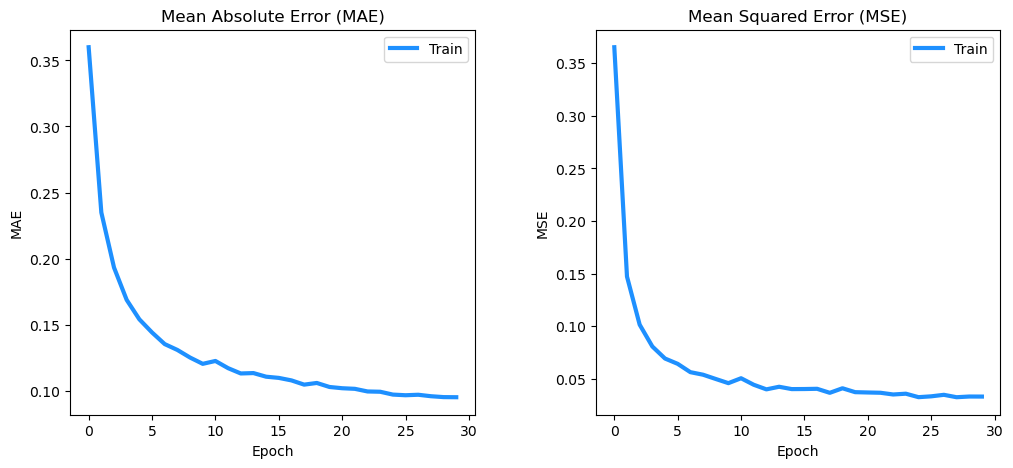

In [10]:
# MAE 그래프
plt.subplot(121)
plt.plot(history['mae'], c='dodgerblue', lw=3)
plt.title('Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')

# MSE 그래프
plt.subplot(122)
plt.plot(history['mse'], c='dodgerblue', lw=3)
plt.title('Mean Squared Error (MSE)')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')

plt.subplots_adjust(wspace=0.3)  # 그래프 사이 간격 조정
plt.gcf().set_size_inches(12, 5)  # 그래프의 가로 길이 조정

plt.show()


위 코드는 모델 훈련 과정에서의 손실 함수(MSE), 평균 절대 오차(MAE), 평균 제곱 오차(MSE)의 변화를 그래프로 나타내는 작업입니다.

* MAE 그래프: 훈련 과정에서 MAE 값의 변화를 나타냅니다.
* MSE 그래프: 훈련 과정에서 MSE 값의 변화를 나타냅니다.

In [11]:
# 훈련된 오토인코더를 사용하여 테스트 세트를 재구성합니다.
pred_X = autoencoder.predict(X)

# 재구성 오차(MSE와 MAE)를 계산합니다.
mse_X = np.mean(np.power(X - pred_X, 2), axis=1)
mae_X = np.mean(np.abs(X - pred_X), axis=1)

# 재구성 오차를 데이터 DataFrame에 추가합니다.
data['mse_X'] = mse_X
data['mae_X'] = mae_X

# Top-N 정확도 평가
n = 1000
df = data.sort_values(by='mae_X', ascending=False)
top_n_df = df.head(n)
accuracy = top_n_df[top_n_df['Class'] == 1].shape[0] / n
print('Top-{} 정확도: {}'.format(n, accuracy))


8901/8901 [==============================] - 13s 1ms/step
Top-1000 정확도: 0.329


위 코드는 훈련된 오토인코더를 사용하여 테스트 세트를 재구성합니다. 재구성 오차(MSE와 MAE)를 계산하고, 이를 데이터 DataFrame에 추가합니다. 그 후, 상위 N개의 샘플을 추출하여 해당 샘플들 중 사기 클래스의 비율을 계산하여 Top-N 정확도를 평가합니다.

* pred_X: 오토인코더를 사용하여 입력 데이터 X의 재구성을 예측한 값
* mse_X: 입력 데이터 X와 재구성된 값 pred_X 사이의 평균 제곱 오차(MSE)
* mae_X: 입력 데이터 X와 재구성된 값 pred_X 사이의 평균 절대 오차(MAE)
* n: 상위 N개의 샘플을 선택하는데 사용되는 값
* df: 데이터를 mae_X 기준으로 내림차순으로 정렬한 DataFrame
* top_n_df: df에서 상위 N개의 샘플을 추출한 DataFrame
* accuracy: 상위 N개의 샘플 중 사기 클래스의 비율, 즉 Top-N 정확도

16/16 [==============================] - 0s 2ms/step


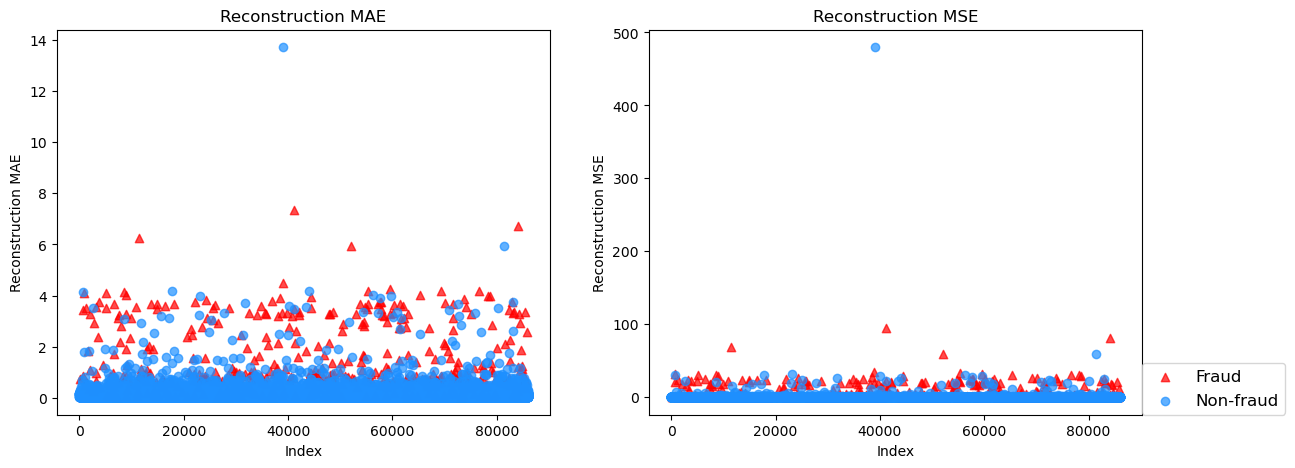

In [12]:
# 'Class'가 0인 행, 즉 부정 행위가 아닌 행을 추출하고, 7:3 비율로 훈련셋과 테스트셋으로 분리
mask = (data['Class'] == 0)
X_train, X_test = train_test_split(X, test_size=0.3, random_state=520)

# 'Class'가 1인 행, 즉 부정 행위를 한 행을 추출하여 테스트셋의 일부로 설정
X_fraud = X[~mask]


# 훈련된 autoencoder를 이용하여 테스트셋을 재구성
pred_test  = autoencoder.predict(X_test)
pred_fraud = autoencoder.predict(X_fraud)


# 재구성 오차인 MSE(평균 제곱 오차)와 MAE(평균 절대 오차) 계산
mse_test = np.mean(np.power(X_test - pred_test, 2), axis=1)
mse_fraud = np.mean(np.power(X_fraud - pred_fraud, 2), axis=1)
mae_test = np.mean(np.abs(X_test - pred_test), axis=1)
mae_fraud = np.mean(np.abs(X_fraud - pred_fraud), axis=1)
mse_df = pd.DataFrame()
mse_df['Class'] = [0] * len(mse_test) + [1] * len(mse_fraud)
mse_df['MSE'] = np.hstack([mse_test, mse_fraud])
mse_df['MAE'] = np.hstack([mae_test, mae_fraud])
mse_df = mse_df.sample(frac=1).reset_index(drop=True)


# 테스트셋에서 정상 샘플과 부정 행위 샘플의 재구성 오차 MAE와 MSE를 그림으로 표현
markers = ['o', '^']
markers = ['o', '^']
colors = ['dodgerblue', 'red']
labels = ['Non-fraud', 'Fraud']

plt.figure(figsize=(14, 5))
plt.subplot(121)
for flag in [1, 0]:
    temp = mse_df[mse_df['Class'] == flag]
    plt.scatter(temp.index, 
                temp['MAE'],  
                alpha=0.7, 
                marker=markers[flag], 
                c=colors[flag], 
                label=labels[flag])
plt.title('Reconstruction MAE')
plt.ylabel('Reconstruction MAE')
plt.xlabel('Index')

plt.subplot(122)
for flag in [1, 0]:
    temp = mse_df[mse_df['Class'] == flag]
    plt.scatter(temp.index, 
                temp['MSE'],  
                alpha=0.7, 
                marker=markers[flag], 
                c=colors[flag], 
                label=labels[flag])
plt.legend(loc=[1, 0], fontsize=12)
plt.title('Reconstruction MSE')
plt.ylabel('Reconstruction MSE')
plt.xlabel('Index')
plt.show()


MAE와 MSE를 보면, 양성 및 음성 샘플 간에 상당한 차이가 있음을 알 수 있습니다. 이는 이 알고리즘이 우수한 이상 탐지 능력을 가지고 있음을 증명합니다. 그러나 일부 정상 샘플은 여전히 이상 탐지를 통해 분리하기 어렵습니다.